In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from cleaning import df
sns.set()

I also want to add columns representing the positions of each player. I do so by creating dummy variables for the `pos` column.

In [2]:
df = pd.get_dummies(df, columns=['pos'])

These are the steps I am going to take to perform my analysis. I need to figure out which method works best for 

Feature Selection:
- `VarianceThreshold`
- `SelectKBest`
- `SelectFromModel`

Hyperparameter Tuning:
- `GridSearchCV`
- `RandomizedSearchCV`

Learning Model Selection:
- `LogisticRegression`
- `RandomForestClassifier`
- `SVM`
- `KNNeighborsClassifier`


Metrics:
- ROC-AUC
- F1 Score



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 39 columns):
player             3860 non-null object
href               3860 non-null object
height             3860 non-null float64
age                3860 non-null float64
tm                 3860 non-null object
lg                 3860 non-null object
g                  3860 non-null float64
gs                 3860 non-null float64
mp                 3860 non-null float64
fg                 3860 non-null float64
fga                3860 non-null float64
fgp                3860 non-null float64
threep             3860 non-null float64
threepa            3860 non-null float64
threepp            3860 non-null float64
twop               3860 non-null float64
twopa              3860 non-null float64
twopp              3860 non-null float64
efgp               3860 non-null float64
ft                 3860 non-null float64
fta                3860 non-null float64
ftp                3860 non-null flo

# Feature Selection
There are 3 different methods of feature selection that I will consider: `VarianceThreshold`, `SelectKBest`, and `SelectFromModel`.

`VarianceThreshold` removes all features with a variance equal to 0. Since I do not have any columns with the same values throughout, this will not help me reduce the dimensionality of my dataset.

`SelectKBest` selects a defined number of categories, k, that are most descriptive of the data. For classification problems, there are 3 types of tests that can be run to score the features: `chi2`, `f_classif`, and `mutual_info_classif`. `chi2` uses a $\chi^{2}$ test to measure dependence between stochastic varables, so this function removes features that are most likely to be independent of class and therefore irrelevant to classification. However, it requires all positive values, and when I scale my data, some values are below 0.  `f_classif` calculates the ANOVA F-value for the sample which is the ratio of two features' variance. `mutual_info_classif` estimates mutual information for a discrete target variable. If MI between two random variables is 0, they are independent, and a high MI means higher dependency.

For my purposes, I will use `SelectKBest` and use `mutual_info_classif` to determine the best features.

To begin, I set `int_df` equal to the numeric columns of my dataset. I then split it into the feature columns and the target column, `allstar_next`. I then separate each of these new dataframes into training datasets and test datasets. I use StandardizedScaler to preprocess the feature dataset. The target data is binary so no standardization is necesary.

In order to prevent leakage in my model, I fit it to the training set ONLY, and then use this fitted model to transform both the training and test sets.

In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13, 
                                                stratify=target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

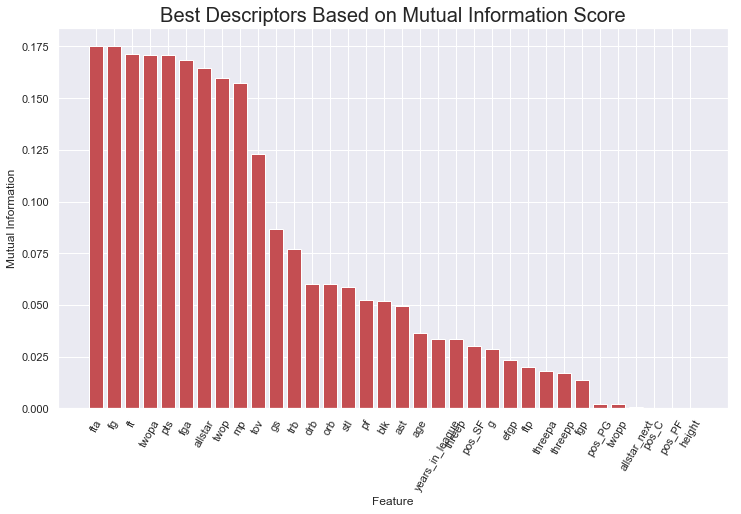

In [5]:
indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(34):
    cols.append(int_df.columns[indices[i]])

# Now plot
plt.figure(figsize=[12,7])
plt.bar(cols, skb.scores_[indices[range(34)]], color='r', align='center')
plt.xticks(rotation=60)
plt.title('Best Descriptors Based on Mutual Information Score', size=20)
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.show()

My 10 most descriptive features are: `fta`, `ft`, `twop`, `fg`, `twopa`, `allstar`, `fga`, `mp`, `tov`, and `gs`. However, I don't know if feature selection is even the best option for me. In order to check this, I will run some tests on the ability of my model to correctly predict my data using different number of features

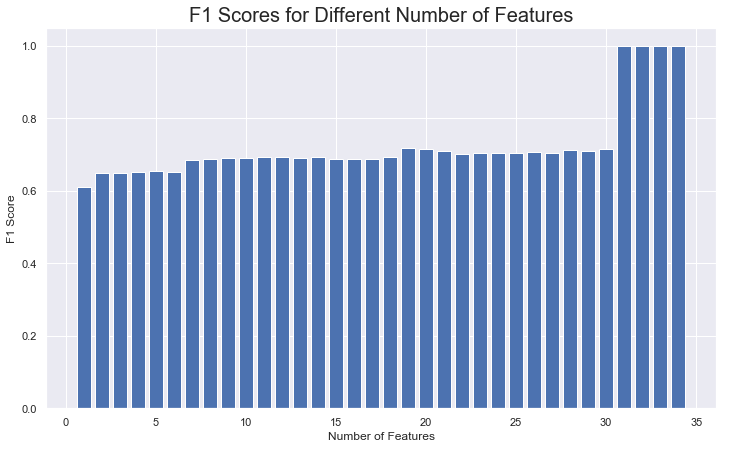

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lr = LogisticRegression(max_iter=10000, solver='lbfgs')
pipeline = make_pipeline(scaler, lr)

f1s = []
for i in range(1, len(kbestfeat)+1):
    
    features = int_df[cols[:i]].values
    target = int_df.loc[:, 'allstar_next'].values

    Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                                    random_state=13, 
                                                    stratify=target)
    
    pipeline.fit(Xtrain, ytrain)
    ypred = pipeline.predict(Xtest)
    
    f1s.append(f1_score(ytest, ypred))
    
plt.figure(figsize=(12,7))
plt.bar(x=range(1, len(kbestfeat)+1), height=f1s);
plt.title('F1 Scores for Different Number of Features', size=20);
plt.xlabel('Number of Features');
plt.ylabel('F1 Score');

Since there is an initial increase in prediction power and then very small increases with more features, I am not going to reduce the dimensionality of my dataset further than I already have. Increased information will hopefully help me tune my model more effectively.

# Logistic Regression
There are a variety of parameters for logistic regression, but many of them do not apply to my question for a variety of reasons or I have made a selection based on the scikit-learn documentation. For instance, while there are many potential solvers many do not make sense for my project. `sag` and `saga` are for very large datasets. Given that I do not have an excess of columns, I want to use L2 penalty rather than L1 which could induce too much sparsity. Using `newton-cg` comes with many problems such as being computationally expensive and being attracted to Saddle Points where it can become confused about whether the input is a maximum or minimum. This leaves me with `liblinear` and `lbfgs`. I will use `lbfgs` because it is the default setting for `LogisticRegression` and will serve my purposes well.

I have determined the following parameters to be most important for my model construction:
- `C`
- `fit_intercept`

I chose to use GridSearchCV over RandomizedSearchCV because the range of parameters and the size of my dataset is not so large as to cause problems. My scoring metric to determine the best model will be the F1 score because in my dataset, there are more seasons where the next year a player is not an allstar than there are seasons where a player is. Looking at accuracy alone would artificially inflate the models success rate.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df[kbestfeat[:10]].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target,
                                               random_state=13)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

lr = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=13)
parameters = {'C':[0.001, 0.1, 1, 10, 10e8],
              'fit_intercept': [True, False]
             }
gscv = GridSearchCV(lr, parameters, cv=5, 
                          scoring = 'f1',
                          error_score=np.nan)


In [8]:
gscv.fit(Xtrain, ytrain)
print('Parameters:\n{}\nF1 Score:{}'.format(gscv.best_params_, 
                                            gscv.best_score_))
C = gscv.best_params_['C']
fit_intercept = gscv.best_params_['fit_intercept']

Parameters:
{'C': 1000000000.0, 'fit_intercept': False}
F1 Score:0.7009832922682947


Based off of the grid search results, my parameters for the model should be:
- `C`: 10e8
- `fit_intercept`: False

I now want to test my model's effectiveness at predicting new data. Below I set up a pipeline to standardize the data and then perform logistic regression on the test samples. I will then produce a confusion matrix, classification report, and ROC curve.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target)
scaler = StandardScaler()

lr = LogisticRegression(C=C, fit_intercept=fit_intercept,
                       max_iter=10000, solver='lbfgs')

pipeline = make_pipeline(scaler, lr)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yproblr = pipeline.predict_proba(Xtest)


print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[470 143]
 [ 66 286]]
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82       613
         1.0       0.67      0.81      0.73       352

    accuracy                           0.78       965
   macro avg       0.77      0.79      0.78       965
weighted avg       0.80      0.78      0.79       965



Next I calculate some scoring metrics. I will be graphing them at the end with the other classifiers.

In [10]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve

fprlr, tprlr, threshold = roc_curve(ytest, ypred)
roc_auclr = auc(fprlr, tprlr)

yproblr = yproblr[:, 1]
precisionlr, recalllr, thresholdslr = precision_recall_curve(ytest, yproblr)
pr_auclr = auc(recalllr, precisionlr)

# Random Forest Classifier
I now want to explore using a Random Forest Classifier on my data. `RandomForestClassifer` has even more parameters than `LogisticRegression`, so I will use `RandomizedSearchCV` for this testing. After looking through the documentation, I believe the following parameters are most important to do grid search on:

`n_estimators` represents the number of trees in the forest. With more trees, the model better learns the data, but having too many leads to overfitting and slows down the training process considerably.

`max_depth` is how many splits each tree will have. If it is too high, then the model overfits to the training data.

`max_features` represents the number of features to consider when looking for the best split. At high values, it leads to overfitting.

To get an idea of what values to use for n_estimators and max_depth, I wanted to graph how the changes in their values affect the ability of my model accuracy. I used the ROC AUC to test.

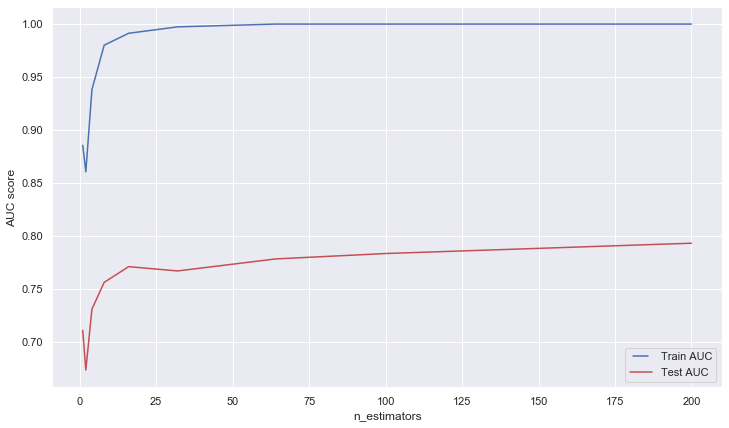

In [11]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify=target)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(12,7))
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

Next I created a similar graph for max_depth.

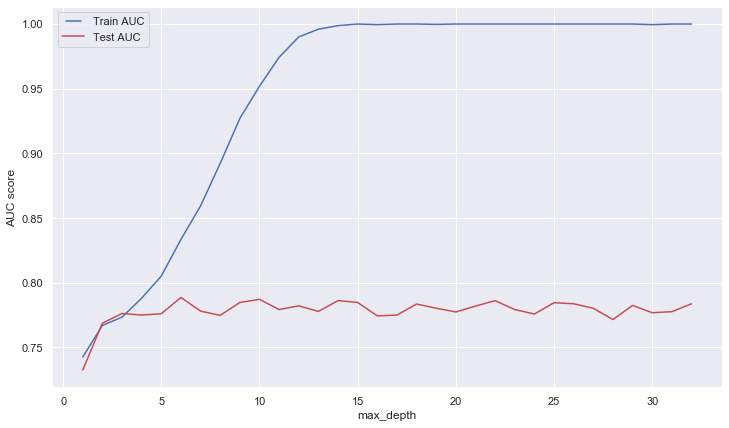

In [12]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify=target)

max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

plt.figure(figsize=(12,7))
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

Based on this graph, overfitting happens relatively quickly for my dataset. A lower max_depth will lead to the best model.

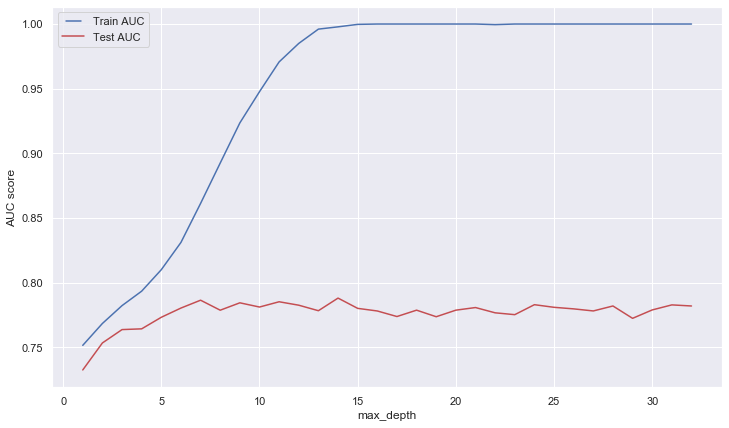

In [13]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify=target)

max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

plt.figure(figsize=(12,7))
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                               stratify=target,
                                               random_state=13)

rfc = RandomForestClassifier(bootstrap=True)

param_grid = {
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [3, 4, 5, 6]
}

gscv = GridSearchCV(rfc, param_grid=param_grid, cv=5, 
                          scoring = 'f1',
                          error_score=np.nan)

In [15]:
gscv.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn', n_jobs=

In [16]:
print(gscv.best_params_, gscv.best_score_)

{'max_depth': 5, 'n_estimators': 10} 0.7256656801015855


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                               stratify=target,
                                               random_state=13)

scaler = StandardScaler()
rfc = RandomForestClassifier(n_estimators=200, max_depth=6, bootstrap=True)
pipeline = make_pipeline(scaler, rfc)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yprobrfc = pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[524  89]
 [117 235]]
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       613
         1.0       0.73      0.67      0.70       352

    accuracy                           0.79       965
   macro avg       0.77      0.76      0.77       965
weighted avg       0.78      0.79      0.78       965



In [18]:
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending=False)
feature_imp

allstar            0.162510
ft                 0.086898
fta                0.084092
pts                0.076542
fga                0.072282
mp                 0.071864
fg                 0.069111
twopa              0.061869
twop               0.057938
gs                 0.025500
tov                0.023634
trb                0.023466
ast                0.016475
years_in_league    0.015919
age                0.014203
twopp              0.014114
efgp               0.013414
stl                0.012628
drb                0.012464
fgp                0.011198
blk                0.010118
orb                0.010103
pf                 0.009256
ftp                0.008586
g                  0.007508
threepp            0.007426
threepa            0.006979
threep             0.005727
height             0.005467
pos_C              0.000647
pos_PF             0.000621
pos_SF             0.000573
pos_PG             0.000515
pos_SG             0.000356
dtype: float64

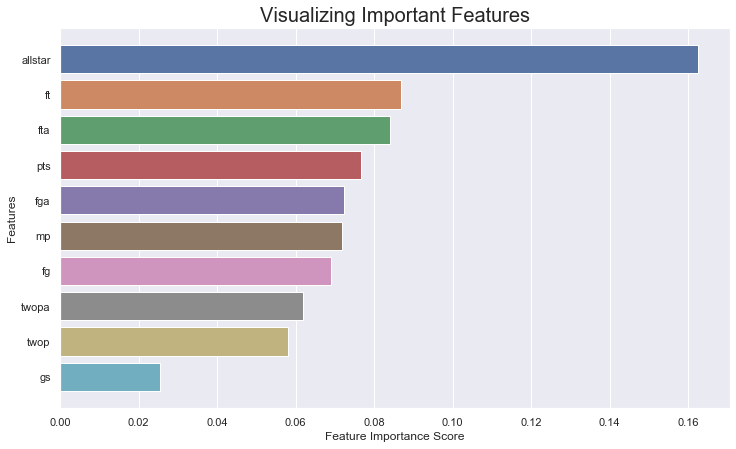

In [19]:
_ = plt.figure(figsize=(12,7))
_ = sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
_ = plt.xlabel('Feature Importance Score')
_ = plt.ylabel('Features')
_ = plt.title('Visualizing Important Features', size=20)
_ = plt.plot()

When looking at the feature importance 

In [20]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve

fprrfc, tprrfc, threshold = roc_curve(ytest, ypred)
roc_aucrfc = auc(fprrfc, tprrfc)

yprobrfc = yprobrfc[:, 1]
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(ytest, yprobrfc)
pr_aucrfc = auc(recallrfc, precisionrfc)

Based on this testing, Random Forest Classifier is worse than a Logistic Regression. I will now test Support Machine Vectors.

# Support Vector Machine
Support Vector Machines construct a hyperplane of set of hyperplanes in higher dimensional space in order to classify the data. For my model I will be looking at the value of the penalty term `C` and the `kernel`. There are a few different types of kernels available to use with Support Vector Machines, and I will be testing `rbf` and `poly` kernels to see which is best for my models.

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target,
                                               random_state=13)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

svc = SVC(gamma='scale')

param_grid = {
   'C' : [0.1, 1, 10, 100, 1000000],
    'kernel': ['rbf', 'poly' ]
}

gscv = GridSearchCV(svc, param_grid, cv=5,
                    scoring = 'f1',
                    error_score=np.nan)

In [22]:
gscv.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000000],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [23]:
print(gscv.best_params_, gscv.best_score_)

{'C': 1, 'kernel': 'rbf'} 0.7251300261438658


The best C value for SVM is 1 and the best kernel for me to use is rbf

In [24]:
int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target)
scaler = StandardScaler()

svm = SVC(gamma='scale', C=1, kernel='rbf', probability=True)

pipeline = make_pipeline(scaler, svm)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yprobsvm = pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[521  92]
 [112 240]]
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       613
         1.0       0.72      0.68      0.70       352

    accuracy                           0.79       965
   macro avg       0.77      0.77      0.77       965
weighted avg       0.79      0.79      0.79       965



In [25]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve

fprsvm, tprsvm, threshold = roc_curve(ytest, ypred)
roc_aucsvm = auc(fprsvm, tprsvm)

yprobsvm = yprobsvm[:, 1]
precisionsvm, recallsvm, thresholdssvm = precision_recall_curve(ytest, yprobsvm)
pr_aucsvm = auc(recallsvm, precisionsvm)


# K Nearest Neighbors Classifier
The k

In [26]:
from sklearn.neighbors import KNeighborsClassifier

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target,
                                               random_state=13)
knc = KNeighborsClassifier()

param_grid = {'n_neighbors':[10, 20, 30, 100, 200],
             'weights': ['uniform', 'distance'],
             'p': [1, 2]}

gscv = GridSearchCV(knc, param_grid, cv=5,
                    scoring = 'f1',
                    error_score=np.nan)


In [27]:
gscv.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [10, 20, 30, 100, 200], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [28]:
print(gscv.best_params_, gscv.best_score_)

{'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 0.6980765177128473


In [29]:
int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target)
scaler = StandardScaler()

knc = KNeighborsClassifier(n_neighbors=30, p=1, weights='distance')

pipeline = make_pipeline(scaler, knc)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yprobknc = pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[521  92]
 [102 250]]
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       613
         1.0       0.73      0.71      0.72       352

    accuracy                           0.80       965
   macro avg       0.78      0.78      0.78       965
weighted avg       0.80      0.80      0.80       965



In [30]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve

fprknc, tprknc, thresholdknc = roc_curve(ytest, ypred)
roc_aucknc = auc(fprknc, tprknc)

yprobknc = yprobknc[:, 1]
precisionknc, recallknc, thresholdsknc = precision_recall_curve(ytest, yprobknc)
pr_aucknc = auc(recallknc, precisionknc)

# Model Comparison

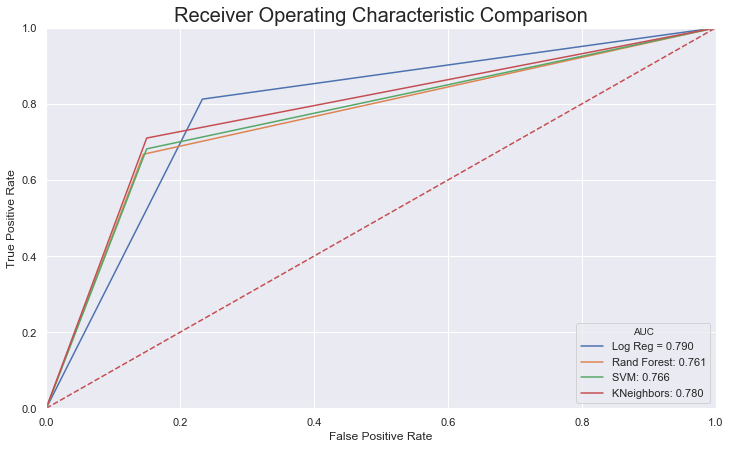

In [31]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Receiver Operating Characteristic Comparison', size=20)
_ = plt.plot(fprlr, tprlr, label = 'Log Reg = %0.3f' % roc_auclr)
_ = plt.plot(fprrfc, tprrfc, label='Rand Forest: %0.3f' % roc_aucrfc)
_ = plt.plot(fprsvm, tprsvm, label='SVM: %0.3f' % roc_aucsvm)
_ = plt.plot(fprknc, tprknc, label='KNeighbors: %0.3f' % roc_aucknc)
_ = plt.legend(title='AUC', loc = 'lower right')
_ = plt.plot([0, 1], [0, 1],'r--')
_ = plt.xlim([0, 1])
_ = plt.ylim([0, 1])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')
_ = plt.show()

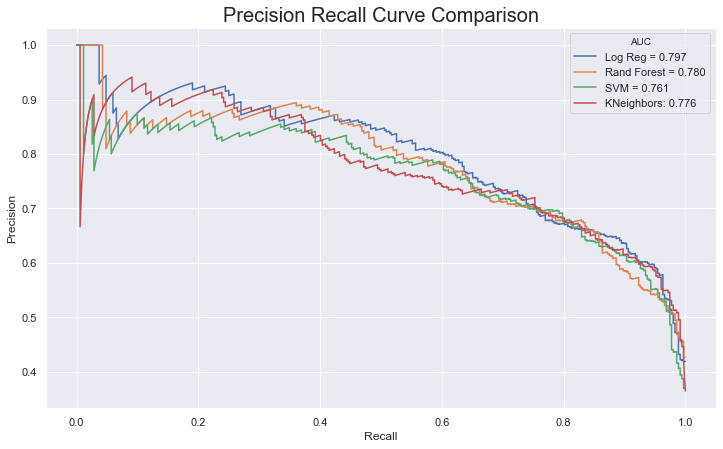

In [32]:
plt.figure(figsize=(12,7));
plt.title('Precision Recall Curve Comparison', size=20);
plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr);
plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc);
plt.plot(recallsvm, precisionsvm, label = 'SVM = %0.3f' % pr_aucsvm);
plt.plot(recallknc, precisionknc, label = 'KNeighbors: %0.3f' % pr_aucknc);
#plt.xlim([0, 1]);
#plt.ylim([0, 1]);
plt.ylabel('Precision');
plt.xlabel('Recall');
plt.legend(title='AUC')
plt.show();

ROC curves are great for classification problems as are Precision-Recall curves, but ROC AUC can be artificially inflated in unbalanced datasets which can be mitigated by using a Precision-Recall Curve. I have created both since my data is a little unbalanced.

# Misclassifications

A huge question I have after modeling my data is what data points were misclassified. There may be a trend there that could help me identify why my model is not performing as well as I would hope. To do so, I am going to split my data and train each model. From there I will predict values and compare which seasons were misclassified across all three models.

In [33]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                               stratify=target,
                                               random_state=25)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

lr = LogisticRegression(C=C, fit_intercept=fit_intercept,
                       max_iter=10000, solver='lbfgs')
lr.fit(Xtrain, ytrain)
ypred_lr = lr.predict(Xtest)

rfc = RandomForestClassifier(n_estimators=200, max_depth=6,
                             bootstrap=True)
rfc.fit(Xtrain, ytrain)
ypred_rfc = rfc.predict(Xtest)

svm = SVC(gamma='scale', C=1, kernel='rbf')
svm.fit(Xtrain, ytrain)
ypred_svm = svm.predict(Xtest)

knc = KNeighborsClassifier(n_neighbors=30, p=1, weights='distance')
knc.fit(Xtrain, ytrain)
ypred_knc = knc.predict(Xtest)

In [34]:
sum((ytest != ypred_lr) & (ytest != ypred_rfc) & (ytest != ypred_svm) & (ytest != ypred_knc))

128

There are 128 instances in my test set where all 3 models incorrectly predicted the value. This is a majority of the misclassified values, so if I can find a common thread running between these players, then I may be able to improve my model significantly. In order to check for trends in the misclassifications, I want to take a look at the difference in mean values between my misclassified samples and the entire dataset. As you can see below, the values of misclassified seasons are all right around the overall mean for the data. Intermediate values are difficult to parse out when compared to extremes.

In [35]:
ytest_df = df.iloc[ytest.index]
misclass = ytest_df[(ytest != ypred_lr) & (ytest != ypred_rfc) & (ytest != ypred_svm)]
misclass.mean()-df.mean()

height              0.021572
age                -0.551794
g                   4.816414
gs                 10.224744
mp                  3.265717
fg                  1.165050
fga                 2.219233
fgp                 0.014039
threep              0.019221
threepa             0.083184
threepp             0.005187
twop                1.205373
twopa               2.318130
twopp               0.011586
efgp                0.003582
ft                  0.767943
fta                 0.972938
ftp                 0.003976
orb                 0.192193
drb                 0.336860
trb                 0.545704
ast                 0.270939
stl                 0.135107
blk                 0.051232
tov                 0.257721
pf                  0.226301
pts                 3.053557
allstar             0.213127
years_in_league    -0.693709
allstar_next        0.090716
pos_C               0.013151
pos_PF             -0.001465
pos_PG             -0.044931
pos_SF             -0.025358
pos_SG        

# Takeaways and Next Steps
These models achieve similar levels of success. Their ROC-AUC and Precision-Recall AUC values are very similar, but Logistic Regression has the highest followed by Support Vector Machine and then Random Forest Classifier. I initially tried to consider the player's position by adding dummy variables to the dataframe to represent them. However, I believe that if I began by separating players by positions and then put them through the models, my results would be better. Additionally, I think increasing my sample size would give me better distinctions between the allstars and non-allstars. More variables to work with that measure other factors of a player's performance such as team success could also improve the models.

Furthermore, when I run t-SNE on my data, I get an interesting result. The separation between allstars and not allstars is not obvious, but there is a three lobed structure. For future analysis, I could run an unsupervised learning algorithm like K-means clustering to define the clusters and then take a look at the individuals in each cluster to try to determine why the data breaks down how it does.

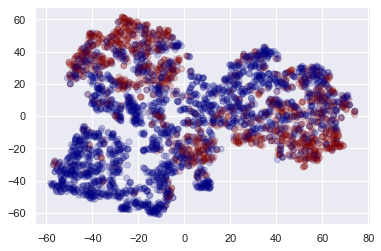

In [36]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

model = TSNE(learning_rate=100)
transformed = model.fit_transform(int_df, y=target)
xs = transformed[:, 0]
ys = transformed[:, 1]
_ = plt.scatter(xs, ys, c=target, cmap='jet', alpha = 0.2)
_ = plt.show()